<a href="https://colab.research.google.com/github/ashikshafi08/Zero-to-Mastery-TensorFlow-for-Deep-Learning-Exercise-Solutions/blob/main/on_hold/%F0%9F%9B%A0_10_Time_series_fundamentals_and_Milestone_Project_3_BitPredict_%F0%9F%92%B0%F0%9F%93%88_Exercise_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 10. Time series fundamentals and Milestone Project 3: BitPredict 💰📈 Exercise Solutions 

1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
    * Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.
2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).
    * You can download the Bitcoin historical data for free from  [coindesk.com/price/bitcoin](https://www.coindesk.com/price/bitcoin)  and clicking “Export Data” -> “CSV”.
3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?
    * Setup a series of experiments to find whether or not there’s a better window size.
    * For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.
4. Create a windowed dataset just like the ones we used for model_1 using  [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)  and retrain model_1 using the recreated dataset.
5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.
    * Are there any other features you think you could add?
    * If so, try it out, how do these affect the model?
6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.
7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn’t retrained for every forecast (model_9)?
8. Throughout this notebook, we’ve only tried algorithms we’ve handcrafted ourselves. But it’s worth seeing how a purpose built forecasting algorithm goes.
    * Try out one of the extra algorithms listed in the modelling experiments part such as:
	*  [Facebook’s Kats library](https://github.com/facebookresearch/Kats)  - there are many models in here, remember the machine learning practioner’s motto: experiment, experiment, experiment.
	*  [LinkedIn’s Greykite library](https://github.com/linkedin/greykite) 


## Downloading the data and preprocessing it 

In [128]:
# Download Bitcoin historical data from GitHub 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

# Import with pandas 
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

--2021-09-12 15:20:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2021-09-12 15:20:32 (9.09 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [129]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head() , bitcoin_prices.shape

(                Price
 Date                 
 2013-10-01  123.65499
 2013-10-02  125.45500
 2013-10-03  108.58483
 2013-10-04  118.67466
 2013-10-05  121.33866, (2787, 1))

In [130]:
# Get the data in array 
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

# Instantiating the sklearn MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 

In [131]:
# Create function to view NumPy arrays as windows 

def get_labelled_windows(x , horizon):
  return x[:, :-horizon] ,x[: , -horizon:]


def make_windows_scaled(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size. Also applies the standard scaler
  """
  scaler.fit(np.expand_dims(x , axis =1))
  scaled_x = scaler.transform(np.expand_dims(x , axis = 1))
  scaled_x = np.squeeze(scaled_x)
  
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(scaled_x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  windowed_array = scaled_x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


# Make the splits 
def make_train_test_splits(windows , labels , test_split = 0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows ,  test_windows ,train_labels,  test_labels

### 1. Does scaling the data help for univariate/multivariate data? (e.g. getting all of the values between 0 & 1)
* Try doing this for a univariate model (e.g. model_1) and a multivariate model (e.g. model_6) and see if it effects model training or evaluation results.

In [132]:
# Model 1 (Horizon = 1 , Window_size = 7)
HORIZON = 1 
WINDOW_SIZE = 7 


full_windows , full_labels = make_windows_scaled(prices , window_size = WINDOW_SIZE , horizon = HORIZON)
full_windows.shape , full_labels.shape

((2780, 7), (2780, 1))

In [133]:
# Looking at few examples of how price is scaled
for i in range(3):
  print(f'Window: {full_windows[i]} --> Label {full_labels[i]}')

Window: [0.00023831 0.00026677 0.         0.00015955 0.00020168 0.00019087
 0.0002089 ] --> Label [0.00022847]
Window: [0.00026677 0.         0.00015955 0.00020168 0.00019087 0.0002089
 0.00022847] --> Label [0.00024454]
Window: [0.         0.00015955 0.00020168 0.00019087 0.0002089  0.00022847
 0.00024454] --> Label [0.00027478]


In [134]:
# Making train and test splits 
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [135]:
# Building the Model 1 
tf.random.set_seed(42)

# Construct the model 
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation= 'relu') ,
  layers.Dense(HORIZON , activation = 'linear')
])

# Compiling the model 
model_1.compile(loss = 'mae' , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['mae'])

# Fit the model 
model_1.fit(x = train_windows , 
            y = train_labels , 
            epochs = 100 , batch_size = 128 , verbose = 0 , 
            validation_data = (test_windows , test_labels))

In [136]:
# Evaluate the model on test data 
model_1.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 0.0102 - mae: 0.0102


[0.01022376399487257, 0.01022376399487257]

In [137]:
# Making predictions 
model_1_preds = tf.squeeze(model_1.predict(test_windows))

Now doing the same for the Multivariate data especially for the Model 6

In [138]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [139]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): 
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [140]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [141]:
# Scaling the X data 
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(np.expand_dims(y , axis = 1))
y_scaled = np.squeeze(y_scaled)

In [142]:
# Make train and test set splits of the scaled data 
split_size = int(len(X) * 0.8)
X_train, y_train = X_scaled[:split_size], y_scaled[:split_size]
X_test, y_test = X_scaled[split_size:], y_scaled[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [143]:
# Building a Multivariate time series model and fitting it
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
  layers.Dense(128 , activation= 'relu'), 
  layers.Dense(HORIZON)
])

model_6.compile(loss = 'mae' , 
                optimizer = tf.keras.optimizers.Adam())

model_6.fit(X_train , y_train , 
          epochs = 100 ,
          verbose = 0 , batch_size = 128, 
          validation_data = (X_test , y_test))

In [144]:
# Evaluate the model 6 
model_6.evaluate(X_test , y_test)

18/18 [==============================] - 0s 978us/step - loss: 0.0735


0.07352113723754883

### 2. Get the most up to date data on Bitcoin, train a model & see how it goes (our data goes up to May 18 2021).

In [145]:
# Loading the in the latest csv from Coindesk
df_updated = pd.read_csv('/content/BTC_USD_2014-11-02_2021-09-09-CoinDesk.csv' , 
                 parse_dates = ['Date'] , 
                 index_col = ['Date'])

bitcoin_prices_updated = pd.DataFrame(df_updated["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices_updated.head(10) , bitcoin_prices_updated.shape

(                Price
 Date                 
 2014-11-02  325.22633
 2014-11-03  331.60083
 2014-11-04  324.71833
 2014-11-05  332.45666
 2014-11-06  336.58500
 2014-11-07  346.77500
 2014-11-08  344.81166
 2014-11-09  343.06500
 2014-11-10  358.50166
 2014-11-11  368.07666, (2503, 1))

In [146]:
prices_updated = bitcoin_prices_updated['Price'].to_numpy()

In [147]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [148]:
full_windows , full_labels = make_windows(prices_updated)
len(full_windows), len(full_labels)

(2496, 2496)

In [149]:
# Looking at few examples of how price is scaled
for i in range(3):
  print(f'Window: {full_windows[i]} --> Label {full_labels[i]}')

Window: [325.22633 331.60083 324.71833 332.45666 336.585   346.775   344.81166] --> Label [343.065]
Window: [331.60083 324.71833 332.45666 336.585   346.775   344.81166 343.065  ] --> Label [358.50166]
Window: [324.71833 332.45666 336.585   346.775   344.81166 343.065   358.50166] --> Label [368.07666]


In [150]:
# Making train and test splits
train_windows ,  test_windows ,train_labels,  test_labels =  make_train_test_splits(full_windows , full_labels)

len(train_windows) ,  len(test_windows) , len(train_labels),  len(test_labels) 

(1996, 500, 1996, 500)

Now we're building the same Model 1 with the new coindesk data. 

In [151]:
# Building the Model 1 with the updated data
tf.random.set_seed(42)

# Construct the model 
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation= 'relu') ,
  layers.Dense(HORIZON , activation = 'linear')
])

# Compiling the model 
model_1.compile(loss = 'mae' , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['mae'])

# Fit the model 
model_1.fit(x = train_windows , 
            y = train_labels , 
            epochs = 100 , batch_size = 128 , verbose = 0 , 
            validation_data = (test_windows , test_labels))

In [152]:
# Evaluating the model 
model_1.evaluate(test_windows , test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 884.0141 - mae: 884.0141


[884.0140991210938, 884.0140991210938]

### 3. For most of our models we used WINDOW_SIZE=7, but is there a better window size?

* Setup a series of experiments to find whether or not there’s a better window size.
* For example, you might train 10 different models with HORIZON=1 but with window sizes ranging from 2-12.

In [153]:
# Writing a evaluation function based on the preds and targets 
def evaluate_preds(y_true , y_pred):

  # Casting the values to float32 
  y_true = tf.cast(y_true , tf.float32)
  y_pred = tf.cast(y_pred , tf.float32)


  # Calculate the metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true , y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true , y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true , y_pred)
  
  # For longer horizons 
  if mae.ndim > 0:
    mae = tf.reduce_sum(mae)
    mse = tf.reduce_sum(mse)
    rmse = tf.reduce_sum(rmse)
    mape = tf.reduce_sum(mape)

  return {'mae' : mae.numpy() , 
          'mse': mse.numpy() , 
          'rmse': rmse.numpy() , 
          'mape': mape.numpy() }

In [154]:
# Writing a for loop to iterate over the Window size and build 10 different models

# 10 Different models with window size ranging from (2 - 12) and store the results
model_results_list = []

from tqdm import tqdm
for size in tqdm(range(2,12)):
  HORIZON = 1 
  WINDOW_SIZE = size

  # Making window and labels 
  full_windows , full_labels = make_windows(prices, window_size= WINDOW_SIZE , horizon= HORIZON)
  

  # Splitting the data in train and test
  train_windows ,  test_windows ,train_labels,  test_labels = make_train_test_splits(full_windows , full_labels)


  # Building a simple dense model
  input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer')
  x = layers.Dense(128 , activation= 'relu')(input)
  output = layers.Dense(HORIZON , activation= 'linear')(x)

  # Packing into a model 
  model = tf.keras.Model(input , output , name = f'model_windowed_{size}')

  # Compiling and fitting the model 
  model.compile(loss = 'mae' , optimizer = 'adam' , metrics = 'mae')

  model.fit(train_windows , train_labels , 
            epochs = 100 , verbose = 0 , 
            batch_size = 128 , 
            validation_data = (test_windows , test_labels))
  

  # Making predictions 
  preds_ = model.predict(test_windows)
  y_preds = tf.squeeze(preds_)

  results = evaluate_preds(tf.squeeze(test_labels) , y_preds)
  model_results_list.append(results)
 

100%|██████████| 10/10 [00:53<00:00,  5.34s/it]


In [155]:
# Below are the 10 different models result 
model_results_list

[{'mae': 569.15063, 'mape': 2.527791, 'mse': 1159396.8, 'rmse': 1076.7529},
 {'mae': 565.61005, 'mape': 2.5274613, 'mse': 1139677.9, 'rmse': 1067.557},
 {'mae': 623.4455, 'mape': 2.8342047, 'mse': 1266272.4, 'rmse': 1125.2877},
 {'mae': 565.611, 'mape': 2.5193882, 'mse': 1157947.0, 'rmse': 1076.0795},
 {'mae': 575.82715, 'mape': 2.5713227, 'mse': 1181491.9, 'rmse': 1086.9645},
 {'mae': 624.6512, 'mape': 2.8559427, 'mse': 1279309.4, 'rmse': 1131.0656},
 {'mae': 673.8467, 'mape': 3.155991, 'mse': 1400997.6, 'rmse': 1183.6375},
 {'mae': 661.0687, 'mape': 3.0541995, 'mse': 1343185.1, 'rmse': 1158.9586},
 {'mae': 583.37537, 'mape': 2.6407204, 'mse': 1204248.0, 'rmse': 1097.3823},
 {'mae': 701.847, 'mape': 3.2888002, 'mse': 1443913.1, 'rmse': 1201.6294}]

### 4. Create a windowed dataset just like the ones we used for model_1 using  [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)  and retrain model_1 using the recreated dataset.

In [156]:
WINDOW_SIZE = 7 
HORIZON = 1

In [157]:
# Make the splits 
def make_train_test_splits(windows , labels , test_split = 0.2):
  split_size = int(len(windows) * (1 - test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows ,  test_windows ,train_labels,  test_labels

In [158]:
ds = tf.keras.utils.timeseries_dataset_from_array(
    data = prices , targets = prices , sequence_length = WINDOW_SIZE , sequence_stride = HORIZON, 
    batch_size = 128
)

In [159]:
train_size , test_size = int(0.8 * len(ds)) ,int(0.2 * len(ds))

In [160]:
train_ds = ds.take(train_size)
test_ds = ds.skip(train_size).take(test_size)

In [161]:
for x , y in train_ds.take(1):
  print(x[:2] , y[:2])

tf.Tensor(
[[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]], shape=(2, 7), dtype=float64) tf.Tensor([123.65499 125.455  ], shape=(2,), dtype=float64)


In [162]:
for x , y in test_ds.take(1):
  print(x[:2] , y[:2])

tf.Tensor(
[[10302.19071368 10301.65965169 10231.42151196 10168.28770938
  10223.5055788  10138.33520522  9984.52051597]
 [10301.65965169 10231.42151196 10168.28770938 10223.5055788
  10138.33520522  9984.52051597 10031.86670899]], shape=(2, 7), dtype=float64) tf.Tensor([10302.19071368 10301.65965169], shape=(2,), dtype=float64)


In [163]:
# Building the Model 1 with the updated data
tf.random.set_seed(42)

# Building a simple dense model
input = layers.Input(shape = (WINDOW_SIZE ,) , name = 'Input_layer' , dtype = tf.float32)
x = layers.Dense(128 , activation= 'relu')(input)
output = layers.Dense(HORIZON , activation= 'linear')(x)

# Packing into a model 
model = tf.keras.Model(input , output)

# Compiling the model 
model.compile(loss = 'mae' , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['mae'])

# Fit the model 
model.fit(train_ds ,
          epochs = 100 , verbose = 0 , 
            validation_data = test_ds)

In [164]:
# Evaluating the model on the test set
model.evaluate(test_ds)

4/4 [==============================] - 0s 20ms/step - loss: 428.2230 - mae: 428.2230


[428.22296142578125, 428.22296142578125]

### 5. For our multivariate modelling experiment, we added the Bitcoin block reward size as an extra feature to make our time series multivariate.

  * Are there any other features you think you could add?
  * If so, try it out, how do these affect the model?

In [165]:
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [166]:
import datetime 

In [167]:
# Creating a day of week feature 
df['day_of_week'] = df.index.dayofweek
df.head(10)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),day_of_week
Date,,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349,1
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383,2
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833,3
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816,4
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566,5
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450,6
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199,0
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066,1
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266,2


In [168]:
# Defining the hyper parameters 
HORIZON = 1 
WINDOW_SIZE = 7 

bitcoin_prices_windowed['day_of_week'] = bitcoin_prices_windowed.index.dayofweek

In [169]:
# Getting three kinds of data (univariate , multivariate and the day of week)

# Univariate data 
full_windows , full_labels = make_windows_scaled(prices)
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)

# Multivaritate dat 
X = bitcoin_prices_windowed.dropna().drop('Price' , axis = 1).astype(np.float32)
X_scaled = scaler.fit_transform(X)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

# Day of week 
day_of_week = bitcoin_prices_windowed.dropna()['day_of_week'].to_list()

In [170]:
# Checking the shapes 
print(full_windows.shape , full_labels.shape)
print(X.shape , y.shape)
print(len(day_of_week))

(2780, 7) (2780, 1)
(2780, 9) (2780,)
2780


In [171]:
# Splitting the multivariate and the day_of_week to train and test splits 
split_size = int(len(X) * 0.8)
train_block_rewards , test_block_rewards = X[:split_size] , X[split_size:]
train_days , test_days = day_of_week[:split_size] , day_of_week[split_size:]
 
len(train_block_rewards), len(train_days) , len(test_block_rewards) , len(test_days)

(2224, 2224, 556, 556)

In [172]:
# Building a performant dataset for train and test 

train_data_tribid = tf.data.Dataset.from_tensor_slices((train_windows , 
                                                        train_block_rewards , 
                                                        train_days))

train_labels_tribid = tf.data.Dataset.from_tensor_slices(train_labels)

# The test/val split 
test_data_tribid = tf.data.Dataset.from_tensor_slices((test_windows , 
                                                       test_block_rewards , 
                                                       test_days))

test_labels_tribid = tf.data.Dataset.from_tensor_slices(test_labels)

# Zipping the data and labels into one complete dataset 
tribid_train_ds = tf.data.Dataset.zip((train_data_tribid , train_labels_tribid))
tribid_test_ds = tf.data.Dataset.zip((test_data_tribid , test_labels_tribid))

# Applying prefetch and batching the dataset 
tribid_train_ds = tribid_train_ds.batch(128).prefetch(tf.data.AUTOTUNE)
tribid_test_ds = tribid_test_ds.batch(128).prefetch(tf.data.AUTOTUNE)

tribid_train_ds ,tribid_test_ds

(<PrefetchDataset shapes: (((None, 7), (None, 9), (None,)), (None, 1)), types: ((tf.float64, tf.float32, tf.int32), tf.float64)>,
 <PrefetchDataset shapes: (((None, 7), (None, 9), (None,)), (None, 1)), types: ((tf.float64, tf.float32, tf.int32), tf.float64)>)

In [173]:
# Building a tribid model 

input_windows = layers.Input(shape = (7,) , dtype=tf.float64 , name='Window Inputs')
exp_layer_1 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_windows)
conv1 = layers.Conv1D(filters= 32 , kernel_size=5 , padding='causal' , activation= 'relu')(exp_layer_1)
window_model = tf.keras.Model(input_windows , conv1 , name = 'Windowed model')

input_blocks = layers.Input(shape = (9,) , dtype= tf.float32 , name ='Block rewards input')
exp_layer_2 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_blocks)
conv2 = layers.Conv1D(filters = 32 , kernel_size= 5 , activation= 'relu' , padding = 'causal')(exp_layer_2)
block_model = tf.keras.Model(input_blocks , conv2 , name = 'Block rewards model')


# Use expand dims to match the same shape output (None , 1 , 128)
# whereas without expand dims it would be (None , 128)
input_days = layers.Input(shape= (1,) , dtype = tf.int32 , name ='Days of week Input')
exp_layer_3 = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(input_days)
dense = layers.Dense(128 , activation= 'relu')(exp_layer_3)
days_model = tf.keras.Model(input_days , dense , name = 'Days Model')

# Concatenating the inputs 
concat = layers.Concatenate(name = 'combined_outputs' )([window_model.output , 
                                                           block_model.output , 
                                                           days_model.output])

# Creating the output layer 
dropout = layers.Dropout(0.4)(concat)
output_layer = layers.Dense(1 , activation = 'linear')(dropout)

# Putting everything into a model 
tribid_model = tf.keras.Model(inputs = [window_model.input , 
                                        block_model.input , 
                                        days_model.input] , 
                              outputs = output_layer)
tribid_model.summary()



Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Window Inputs (InputLayer)      [(None, 7)]          0                                            
__________________________________________________________________________________________________
Block rewards input (InputLayer [(None, 9)]          0                                            
__________________________________________________________________________________________________
Days of week Input (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1, 7)         0           Window Inputs[0][0]              
____________________________________________________________________________________________

In [174]:
# Compiling and fitting the model 
tribid_model.compile(loss = 'mae' , 
                     optimizer = 'adam' , metrics = ['mae'])

# Fitting the model 
tribid_model.fit(tribid_train_ds , 
                 epochs = 20,  
                 validation_data = tribid_test_ds , verbose = 2)

Epoch 1/20
18/18 - 1s - loss: 173.1271 - mae: 173.1271 - val_loss: 124.0174 - val_mae: 124.0174
Epoch 2/20
18/18 - 0s - loss: 96.4324 - mae: 96.4324 - val_loss: 37.3842 - val_mae: 37.3842
Epoch 3/20
18/18 - 0s - loss: 58.4491 - mae: 58.4491 - val_loss: 40.1555 - val_mae: 40.1555
Epoch 4/20
18/18 - 0s - loss: 25.2752 - mae: 25.2752 - val_loss: 25.2996 - val_mae: 25.2996
Epoch 5/20
18/18 - 0s - loss: 6.4564 - mae: 6.4564 - val_loss: 7.1498 - val_mae: 7.1498
Epoch 6/20
18/18 - 0s - loss: 3.2152 - mae: 3.2152 - val_loss: 14.4171 - val_mae: 14.4171
Epoch 7/20
18/18 - 0s - loss: 1.3200 - mae: 1.3200 - val_loss: 5.2407 - val_mae: 5.2407
Epoch 8/20
18/18 - 0s - loss: 0.3744 - mae: 0.3744 - val_loss: 0.3289 - val_mae: 0.3289
Epoch 9/20
18/18 - 0s - loss: 0.2766 - mae: 0.2766 - val_loss: 0.3679 - val_mae: 0.3679
Epoch 10/20
18/18 - 0s - loss: 0.2502 - mae: 0.2502 - val_loss: 0.8294 - val_mae: 0.8294
Epoch 11/20
18/18 - 0s - loss: 0.4526 - mae: 0.4526 - val_loss: 1.4310 - val_mae: 1.4310
Epoch 12

In [175]:
# Evaluating the model 
tribid_model.evaluate(tribid_test_ds)

5/5 [==============================] - 0s 3ms/step - loss: 0.1563 - mae: 0.1563


[0.15634702146053314, 0.15634702146053314]

### 6. Make prediction intervals for future forecasts. To do so, one way would be to train an ensemble model on all of the data, make future forecasts with it and calculate the prediction intervals of the ensemble just like we did for model_8.

**Things to do**
- Train an ensemble model on the whole data. 
- Make one dataset (no test/valid) which will use to predict future forecasts of bitcoins. 
- Make a function that will take the number of iterations and different loss functions to train the model with. 


In [176]:
# Make one whole dataset (with the updated bitcoin prices 2014 - 2021)

X_all = bitcoin_prices_windowed.drop(['Price' , 'block_reward' , 'day_of_week'] , axis = 1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()['Price'].to_numpy()

whole_ds = tf.data.Dataset.from_tensor_slices((X_all , y_all))
whole_ds = whole_ds.batch(128).prefetch(tf.data.AUTOTUNE)
whole_ds

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

In [177]:
# Creating the function 

def get_ensemble_models(horizon = HORIZON , 
                        dataset = whole_ds , 
                        num_iter = 10 , 
                        num_epochs = 100 , 
                        loss_fns = ['mae' , 'mse' , 'mape']):
  

  # Make a empty list of the ensemble models 
  ensemble_models = []

  # Create num_iter number of models per loss functions 
  for i in range(num_iter):
    for loss_functions in loss_fns:
      print(f'Optimizing model by reducing: {loss_functions} for {num_epochs} epochs, model number: {i}')

      model = tf.keras.Sequential([
          layers.Dense(128 , kernel_initializer='he_normal' , activation= 'relu'),
          layers.Dense(128 , kernel_initializer= 'he_normal', activation= 'relu'),
          layers.Dense(HORIZON)
      ])

      # Compiling the model 
      model.compile(loss = loss_functions , 
                    optimizer = 'adam' , metrics = ['mae' , 'mse'])
      
      # Fit the model 
      model.fit(dataset , 
                epochs = num_epochs , 
                verbose = 0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
                                                                patience=100,
                                                                verbose=1)])
      
      ensemble_models.append(model)

  return ensemble_models

In [178]:
# Running the above function 
ensemble_models = get_ensemble_models(num_iter=5 , num_epochs= 1000 , horizon = 1)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 00215: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00418: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00138: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00422: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00259: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00359: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 00269: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00386: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 0

In [179]:
# Making future forecastts of Bitcoins (using the whole data)
def make_future_forecast(values , model_list , into_future , window_size):

  future_forecast = []
  last_window = values[-window_size:]

  for _ in range(into_future): 
    for model in model_list:
    
      future_pred = model.predict(tf.expand_dims(last_window, axis= 0))
      #future_pred = model.predict(last_window)
      print(f'Predicing on: \n {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')

      future_forecast.append(tf.squeeze(future_pred).numpy())

      # Update the last window 
      last_window = np.append(last_window , future_pred)[-window_size:]
  return future_forecast

In [180]:
# Getting the future forecast 
future_forecast = make_future_forecast(y_all , ensemble_models , into_future= 14 , window_size = 7 )

Predicing on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] --> Prediction: 56175.19921875

Predicing on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56175.19921875] --> Prediction: 53977.78125

Predicing on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56175.19921875 53977.78125   ] --> Prediction: 48286.578125

Predicing on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56175.19921875 53977.78125    48286.578125  ] --> Prediction: 49753.5859375

Predicing on: 
 [47885.62525472 45604.61575361 43144.47129086 56175.19921875
 53977.78125    48286.578125   49753.5859375 ] --> Prediction: 45806.8046875

Predicing on: 
 [45604.61575361 43144.47129086 56175.19921875 53977.78125
 48286.578125   49753.5859375  45806.8046875 ] --> Prediction: 45975.1015625

Predicing on: 
 [43144.47129086 56175.19921875 53977.78125    48286.578125


### 7. For future predictions, try to make a prediction, retrain a model on the predictions, make a prediction, retrain a model, make a prediction, retrain a model, make a prediction (retrain a model each time a new prediction is made). Plot the results, how do they look compared to the future predictions where a model wasn’t retrained for every forecast (model_9)?


### 8. Throughout this notebook, we’ve only tried algorithms we’ve handcrafted ourselves. But it’s worth seeing how a purpose built forecasting algorithm goes.

* Try out one of the extra algorithms listed in the modelling experiments part such as:
	*  [Facebook’s Kats library](https://github.com/facebookresearch/Kats)  - there are many models in here, remember the machine learning practioner’s motto: experiment, experiment, experiment.
	*  [LinkedIn’s Greykite library](https://github.com/linkedin/greykite) 


In [181]:
# Installing facebooks kats lib 
!pip install kats 

In [182]:
# Importing the TimeSerisData class from Kats 
from kats.consts import TimeSeriesData


In [183]:
# Utils to work with Kats 
from dateutil import parser 
from datetime import datetime

In [184]:
# Creating a Dataset object with Kats 
ts_data = TimeSeriesData(time = bitcoin_prices_updated.index , 
               value = bitcoin_prices_updated.Price)

type(ts_data)

kats.consts.TimeSeriesData

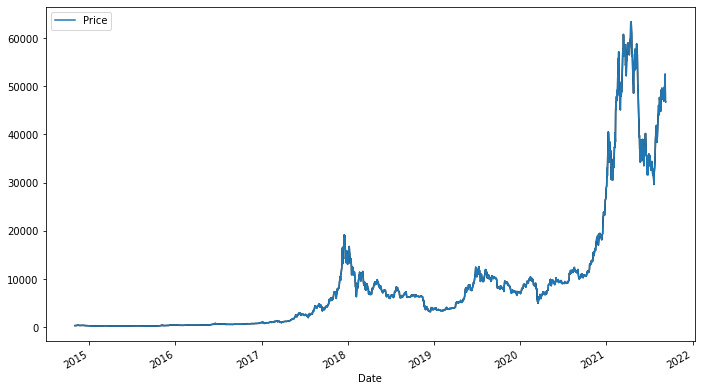

In [185]:
# Plotting the timeseries data 
import matplotlib.pyplot as plt

ts_data.plot(cols=['Price'])
plt.show()


Lets make some forecasting with our data on a prophet model. 

In [186]:
# Importing the prophet 
from kats.models.prophet import ProphetModel , ProphetParams

# Creating a model param instance 
params = ProphetParams(seasonality_mode= 'multiplicative') 

# Create a prophet model instance (just like how we create an instance in sklearn)
model = ProphetModel(ts_data , params)

# Fitting the model 
model.fit() 

# Making predictions 
forecast = model.predict(steps= 1 , include_history= True , freq = '1W')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [187]:
# Predicting the bitcoin price for a day (Horizon = 1 )
forecast.head(10)

,time,fcst,fcst_lower,fcst_upper
0,2014-11-02,100.477979,-1948.078014,2020.033974
1,2014-11-03,100.366334,-2050.732440,2014.143528
2,2014-11-04,100.533908,-1900.069011,2210.730273
3,2014-11-05,100.078650,-1948.428324,2137.642557
4,2014-11-06,101.371062,-1937.311207,2128.023726
5,2014-11-07,100.766892,-1782.054259,2138.806242
6,2014-11-08,101.996420,-1980.782147,2296.454414
7,2014-11-09,102.773991,-1879.018874,2230.720342
8,2014-11-10,103.027023,-1799.212598,1962.218218
9,2014-11-11,103.665574,-1978.564787,2033.804404


The above shows the simple implementation of the Kat's library. And we have used a Prophet model with multiplicative seasonlity. 

Feel free to play with other parameters as well. 

Next we will look into creating a ensemble of models using the Kat's library. We can achieve this by using `KatEnsemble`, it will be kinda similar to how scikit-learn works. 

In [188]:
# Importing the things we need 
from kats.models.ensemble.ensemble import EnsembleParams , BaseModelParams 
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima, 
    holtwinters , 
    linear_model , 
    prophet , 
    quadratic_model , 
    sarima , 
    theta
)

On the next step we will define parameters for each individual forecasting model using the `EnsembleParams` class. 

In [189]:
# Defining the parameters of different models 
model_params = EnsembleParams(
    [
     BaseModelParams('arima' , arima.ARIMAParams(p = 1 , d=1 , q=1)) , 
     BaseModelParams('sarima' ,
                     sarima.SARIMAParams(
                         p = 2 , d= 2 , q =1 , trend = 'ct' , 
                     seasonal_order = (1, 0 ,1 ,12) , enforce_invertibility = False , 
                     enforce_stationarity = False),
     ),
     BaseModelParams('prophet' , prophet.ProphetParams()) , 
     BaseModelParams('linear' , linear_model.LinearModelParams()) , 
     BaseModelParams('quadratic' , quadratic_model.QuadraticModelParams()),
     BaseModelParams('theta' , theta.ThetaParams()), 
    ]
)

In [190]:
# Creating KatEnsembleParam with detailed configuration 
KatEnsembleParams = {
    'models': model_params , 
    'aggregation': 'median' , 
    'seasonality_length': 7 , 
    'decomposition_method': 'multiplicative'
}

In [191]:
# Creating a Time Series dataset 
bitcoin_ts = TimeSeriesData(value = bitcoin_prices.Price,
                            time = bitcoin_prices.index , 
                            sort_by_time= True)

In [192]:
# Creating a KatEnsemble model (or) instantiating it 
ensemble_model = KatsEnsemble(
    data = bitcoin_ts , 
    params = KatEnsembleParams
)

# Fitting the model 
ensemble_model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureW

In [193]:
# Making prediction for the next 30 days 
forecast = ensemble_model.predict(steps = 30) 

In [194]:
# Aggregate individual model results (we will get the predictions for 30 Days)
ensemble_model.aggregate()

,time,fcst,fcst_lower,fcst_upper
0,2021-05-19,42682.033343,38885.538435,44922.406883
1,2021-05-20,42073.837817,38406.420610,44889.006611
2,2021-05-21,41435.525715,37349.861803,44081.146809
3,2021-05-22,42372.449040,38075.124972,45665.318988
4,2021-05-23,42414.698328,37938.263973,45973.660794
5,2021-05-24,41846.072376,37104.568033,45932.084718
6,2021-05-25,40862.114676,35997.432699,45016.413893
7,2021-05-26,41480.060326,36543.312256,46304.086241
8,2021-05-27,40962.347097,35964.142733,46216.077329
9,2021-05-28,40474.565032,35320.389075,45342.487118


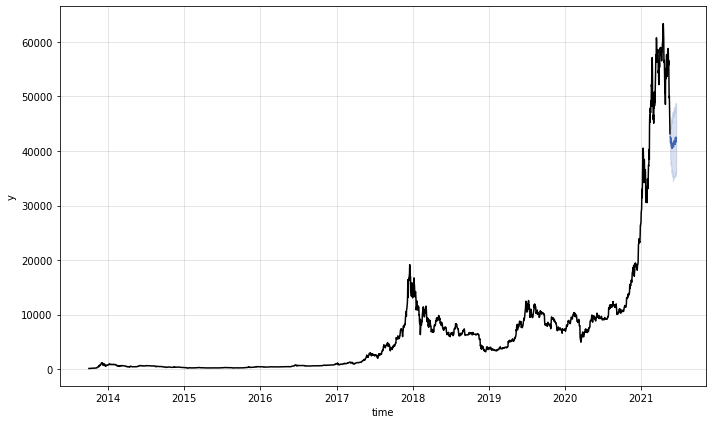

In [195]:
# Plotting the model 
ensemble_model.plot()